In [1]:
import sys
import pandas as pd
import warnings
import seaborn as sns
from typing import List, Union
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pca import pca as pca_func
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sys.path.append('functions')
from data_frame_handler import DataFrameHandler as dfh

# main path to file with data. Can be easily changed
file_path = 'data/urine_test_data.csv'

Step 0: Data prep

In [2]:
df = dfh.read_csv_data(file_path)

# Use a list comprehension to dynamically select matching columns
organisms = dfh.select_columns_by_search_terms(df, ['organism'])
genes = dfh.select_columns_by_search_terms(df, ['gene'])
antibiotics = dfh.select_columns_by_search_terms(df, ['antibiotic'])

# Set the 'Type' column to the values in gene_data_str - FUTURE Labels
gene_data_str = df[genes].applymap(str).agg(''.join, axis=1)
df['Type'] = gene_data_str

In [3]:
# Get a colormap based on the number of unique 'Type' values
geneset_unique_types = df['Type'].unique()
num_unique_types = len(geneset_unique_types)
cmap = plt.get_cmap('tab20', num_unique_types)

# Create a mapping of 'Type' values to colors
type_colors = {type_value: cmap(i) for i, type_value in enumerate(geneset_unique_types)}

# Map 'Type' values to colors in a new Series
type_colors_series = df['Type'].map(type_colors)

Step 1: PCA data preparation

In [4]:
# Assuming 'organisms' contains the organism count variables
X = df[organisms]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Step 2: Perform PCA

In [5]:
# Initialize PCA with the number of components you want to retain
# In this example, let's retain all components for now
pca_model = PCA()

# Fit PCA to the data
pca_model.fit(X_scaled)

PCA()

Step 3: Plot (scree) explained variance. In the cumulative explained variance plot, you'll see the cumulative proportion of total variance explained by each component.

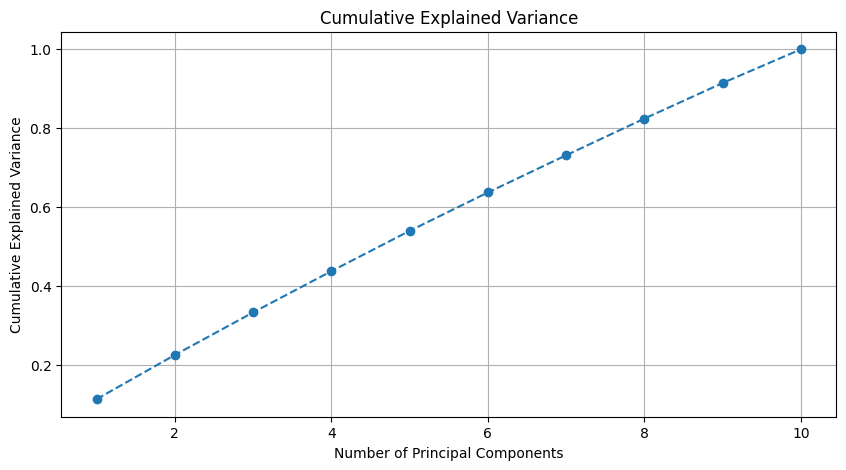

In [6]:
# Plot explained variance
explained_variance = pca_model.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Step 4: Interpretation.
A common rule of thumb is to retain enough components to explain a substantial portion of the total variance, often 95% or more. In this plot, we can see there isn't really a point where the cumulative explained variance levels off. This indicates that PCA may not be waranted here, as there isn't a reflection point of diminishing returns in terms of explaining additional variance.

Step 5: Choose number of components. Based on the chart above, we may be temped to use all possible components. However, this will result in an over-parameterized function and likely not provide any meaningful insight to the data nor useful functions for further predictions. However, for the 'fun' of this exercise, let's go with 8 components to get past at least some quantifiable sigma level.

In [7]:
# Choose the number of components to retain (e.g., n)
n = 8

# Create a new PCA instance with the chosen number of components
pca_model = PCA(n_components=n)

# Fit and transform the data
X_pca = pca_model.fit_transform(X_scaled)

Step 6: Interpret Principal Components.
Interpret the principal components to understand the directions in which the original variables contribute the most to the variance. 
You can inspect the loadings of each principal component to understand which variables have the highest weights.

In [42]:
# Get the loadings for all principal components
loadings_all_components = pca_model.components_

# Create a DataFrame with variable loadings for all components
loadings_df = pd.DataFrame(loadings_all_components, columns=organisms)

# Calculate the explained variance for each component
explained_variance = pca_model.explained_variance_ratio_
loadings_df['Explained Variance'] = explained_variance

# Display the DataFrame
# print("Variable Loadings and Explained Variance for All Principal Components:")
# print(loadings_df)

Let's compare Principal Components to see if we observe any patterns or clustering

Adding in coloring for genetic typing. Creating a matrix to compare all PCs at one glance. Would probably be better to add a plotly-like setup for expanding any given subplot larger.

[scatterd] >INFO> Create scatterplot


[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.
[pca] >Plot PC1 vs PC2 with loadings.


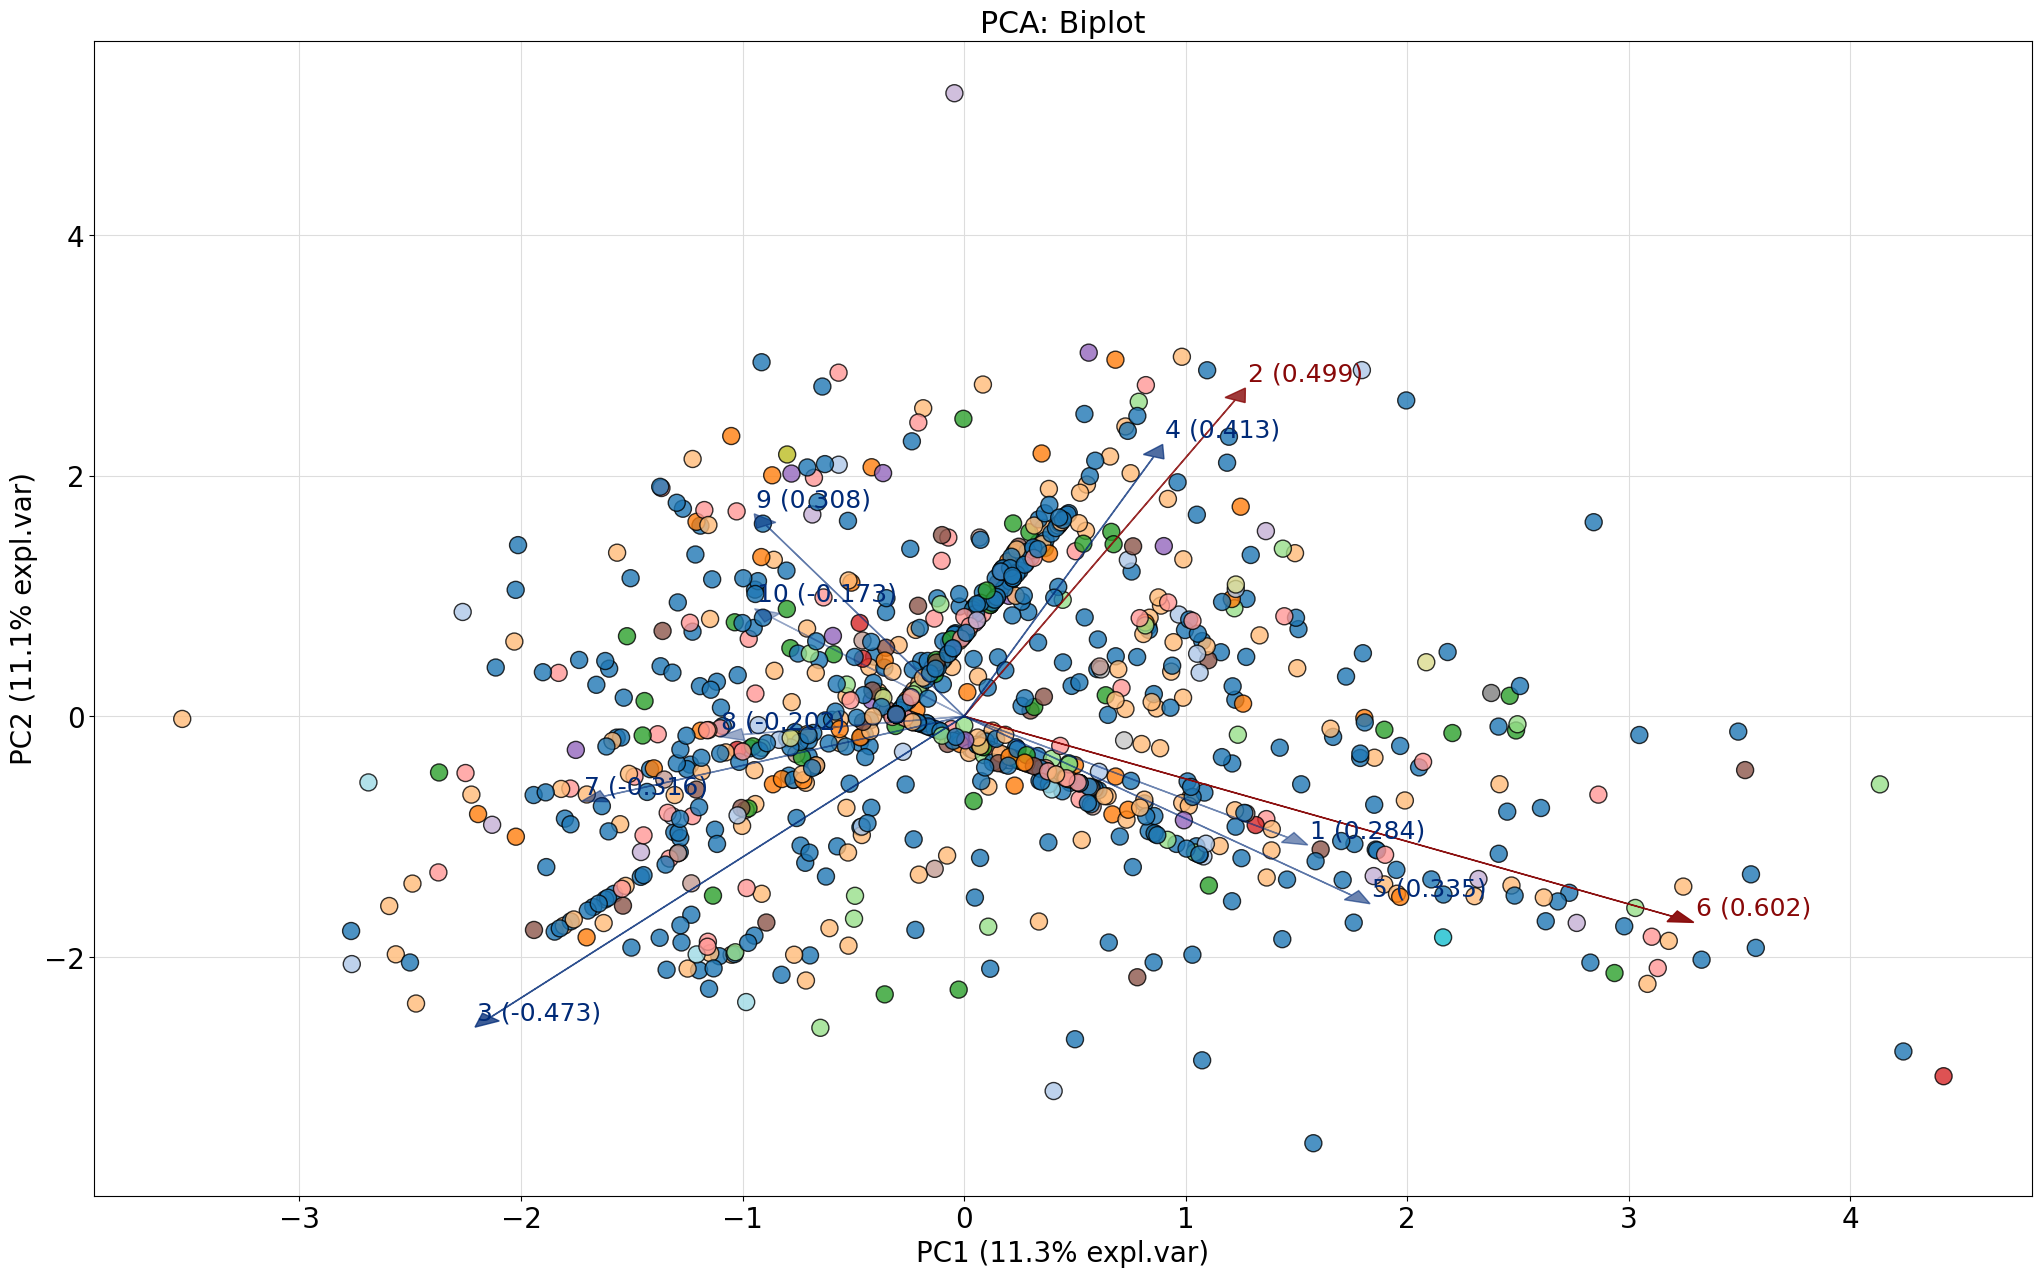

In [11]:
#Biplot: A biplot combines a scatter plot of the data points with vectors representing the loadings of variables on the principal components. 
#This allows you to see how variables and samples relate in the reduced dimensionality space.

# Fit PCA
pca_model2 = pca_func(n_components=2)
pca_results = pca_model2.fit_transform(X_scaled)

# Create biplot
pca_func.biplot(pca_model2, label=True, c=type_colors_series)
plt.title('PCA: Biplot')
plt.show()

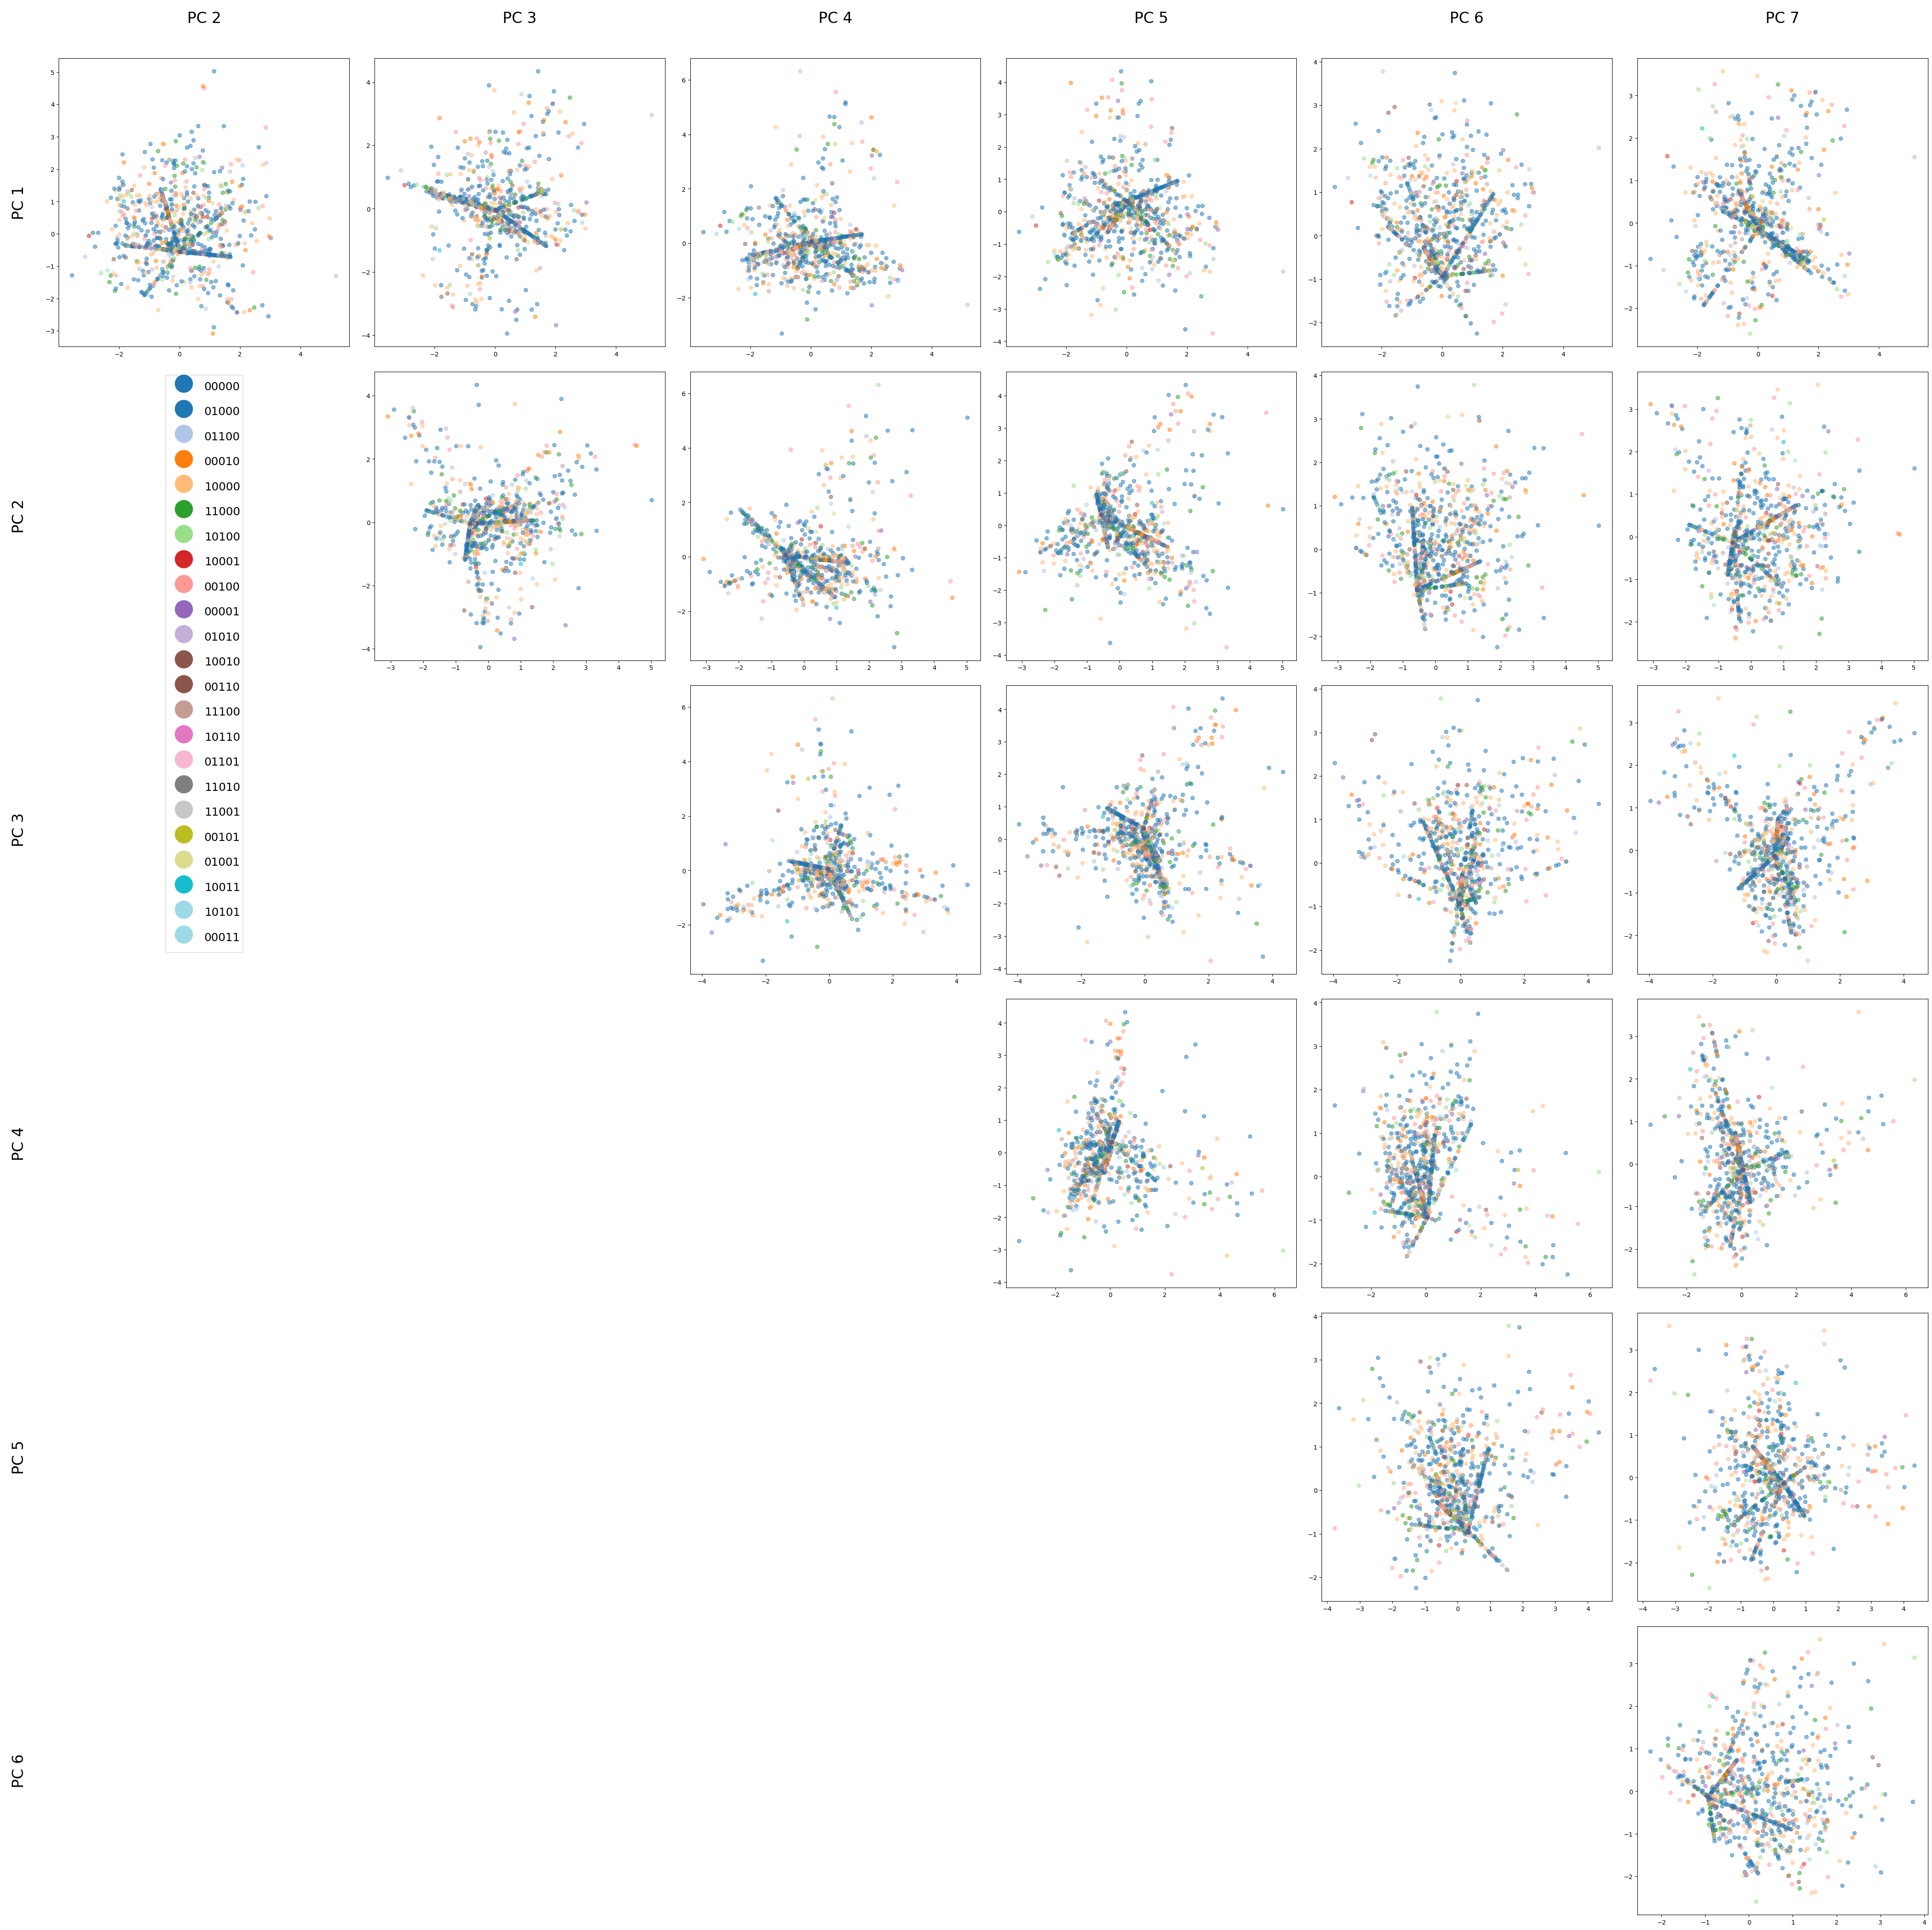

In [10]:
# Row and column labels
row_labels = [f'PC {i}' for i in range(1, n-1)]
col_labels = [f'PC {j}' for j in range(2, n)]

# Create a 6x6 subplot grid with an additional subplot column for labels
fig = plt.figure(figsize=(55, 55))
gs = gridspec.GridSpec(n-1, n-1, wspace=0.1, hspace=0.1, width_ratios=[0.1] + [1]*(n-2), height_ratios=[0.1] + [1]*(n-2))  # Adjust the width ratio for the label column

# Create subplots for data
axes = [[fig.add_subplot(gs[i+1, j+1]) for j in range(n-2)] for i in range(n-2)]

# Create subplots for row labels
row_label_ax = [fig.add_subplot(gs[i, 0]) for i in range(n-1)]
for ax in row_label_ax:
    ax.axis('off')

# Create subplots for column labels
col_label_ax = [fig.add_subplot(gs[0, j]) for j in range(n-1)]
for ax in col_label_ax:
    ax.axis('off')


# Iterate through each combination of PCs
for i in range(1, n-1):
    for j in range(2, n):
        ax = axes[i - 1][j - 2]
        if j > i:
            ax.scatter(X_pca[:, i], X_pca[:, j], c=type_colors_series, alpha=0.5)
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            ax.axis('off')

# Set row labels
for i, label in enumerate(row_labels):
    row_label_ax[i+1].text(0.5, 0.5, label, ha='center', va='center', fontsize=24, rotation=90)

# Set column labels
for j, label in enumerate(col_labels):
    col_label_ax[j+1].text(0.5, 0.5, label, ha='center', va='center', fontsize=24)

# Create a legend for the color mapping
handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=type_colors_series[df['Type'] == type_value].iloc[0], markersize=30, label=type_value)
           for type_value in geneset_unique_types]

# Place legend - set to large size!
ax = axes[1][0]
ax.legend(handles=handles, loc='upper center', handlelength=5, handleheight=5)  # Adjust handlelength and handleheight as needed
legend = ax.get_legend()
for text in legend.get_texts():
    text.set_fontsize(18)

plt.show()

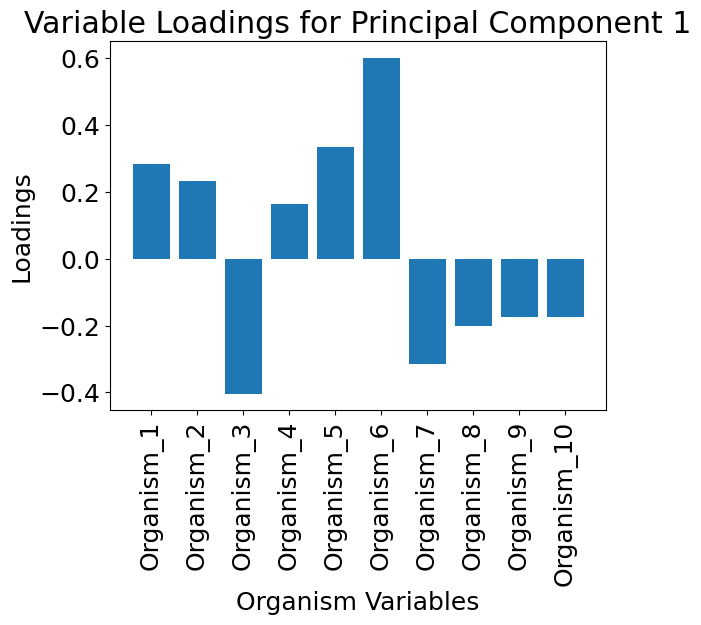

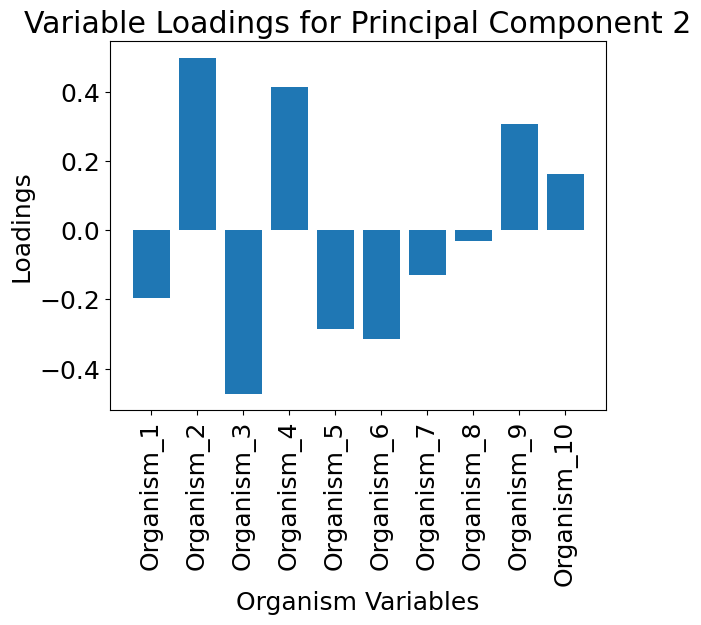

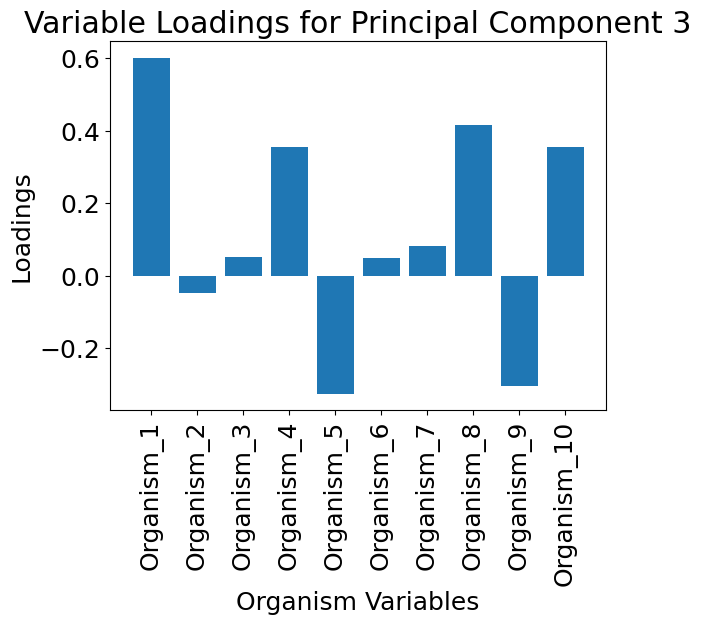

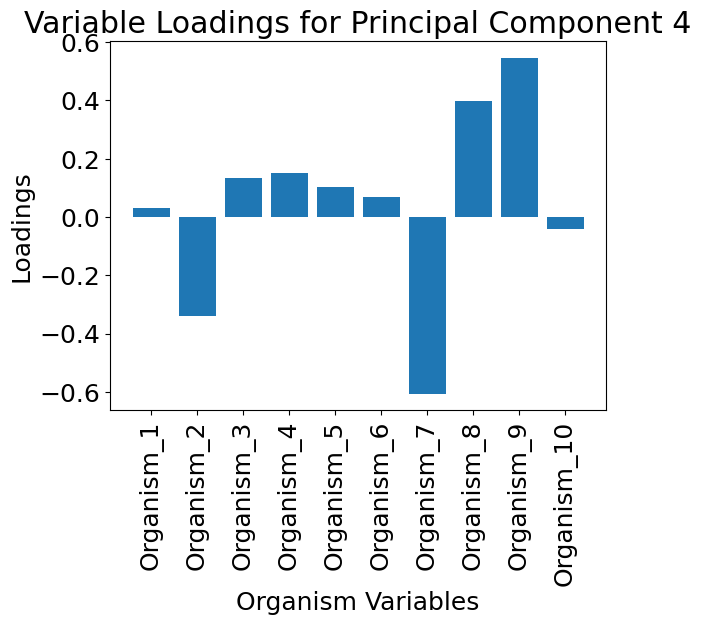

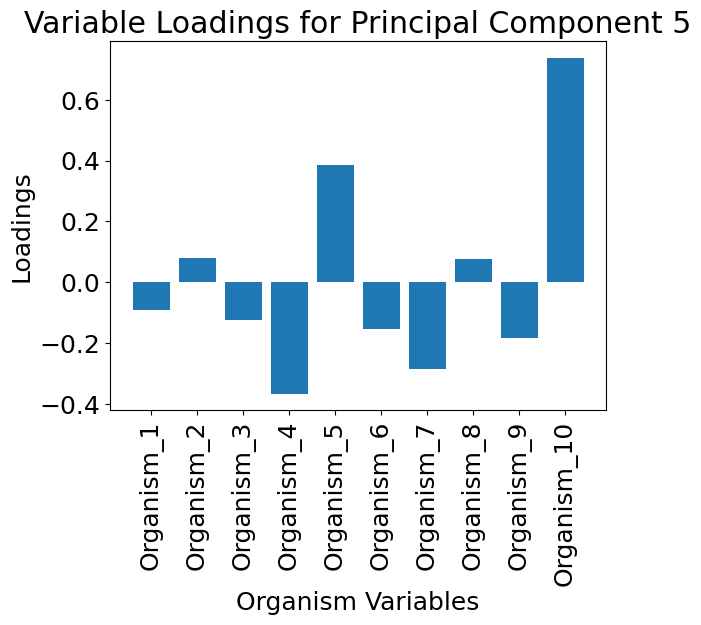

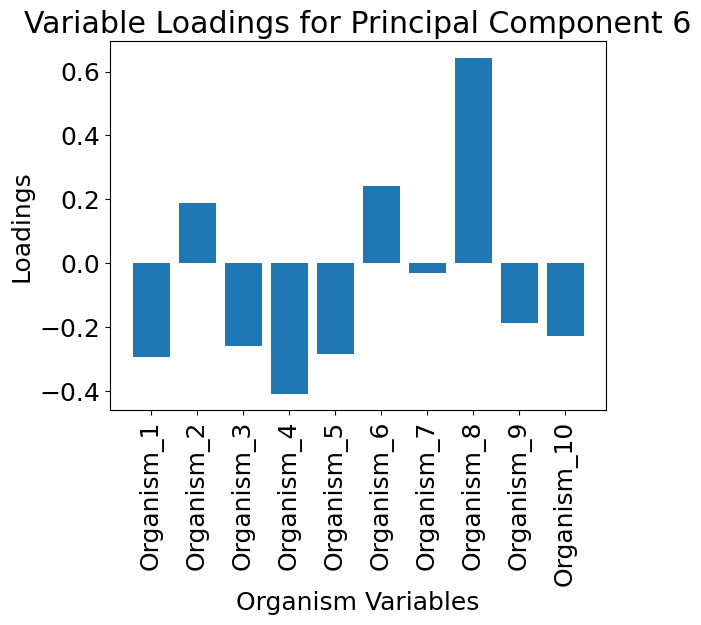

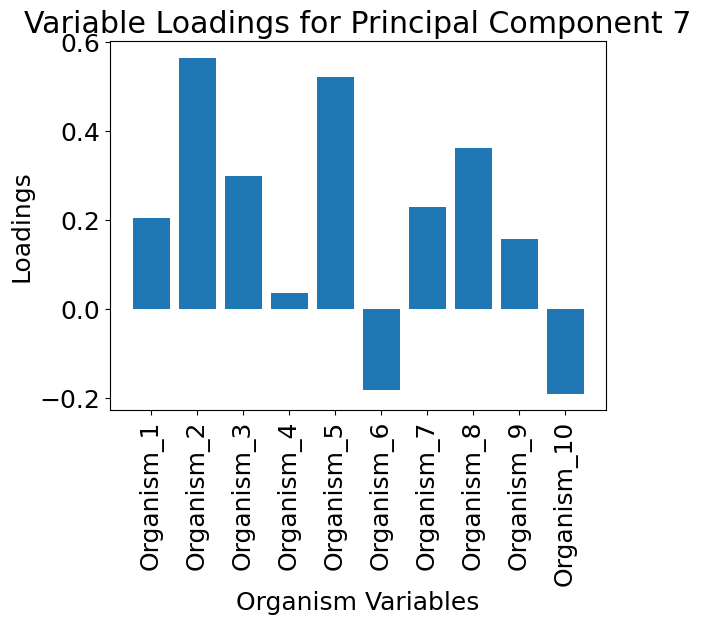

In [12]:
#Variable Loadings Plot: Visualize the loadings of variables on each principal component. This can help you identify which variables contribute the most to each component.

for i in range(0,n-1):
    
    # Plot variable loadings for the first principal component
    plt.bar(range(len(organisms)), pca_model.components_[i], tick_label=organisms)
    plt.xlabel('Organism Variables')
    plt.ylabel('Loadings')
    plt.title(f"Variable Loadings for Principal Component {i+1}")
    plt.xticks(rotation=90)
    plt.show()


In [13]:
#Scree Plot: Plot the explained variance for each principal component. 
#It provides information about how much variance is explained by each component and can help you decide how many components to retain.

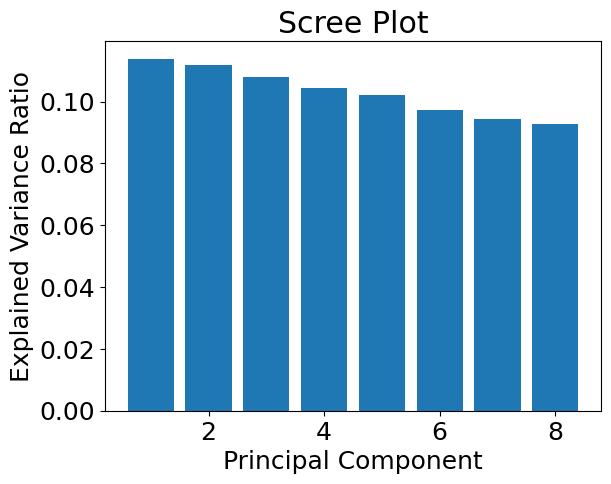

In [14]:
explained_variance = pca_model.explained_variance_ratio_
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

Heatmap of Correlation: Create a heatmap to visualize the correlations between variables and principal components, 
which can provide insights into which variables are strongly associated with which components.

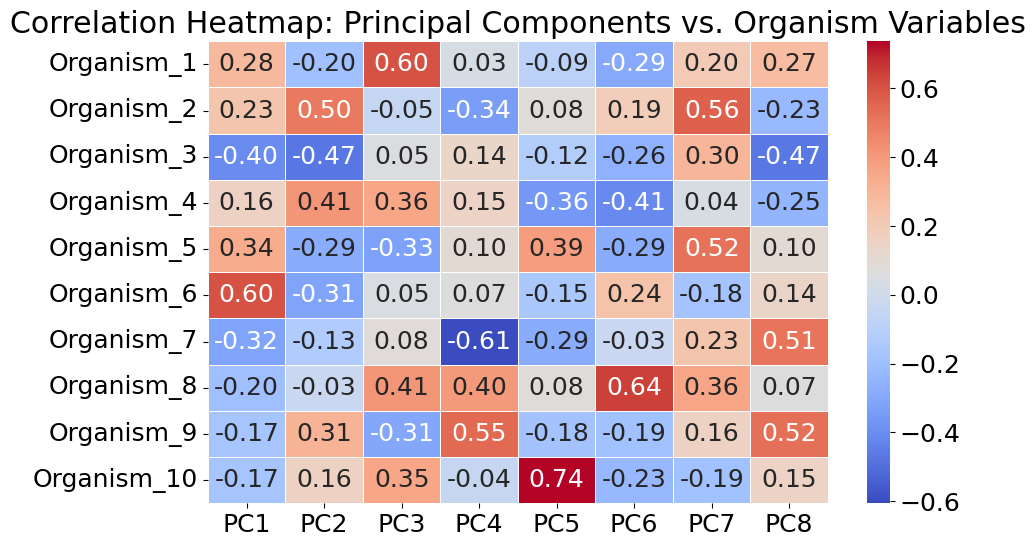

In [15]:
import seaborn as sns

component_variable_correlation = pd.DataFrame(pca_model.components_.T, columns=[f'PC{i}' for i in range(1, n+1)], index=organisms)
plt.figure(figsize=(10, 6))
sns.heatmap(component_variable_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Principal Components vs. Organism Variables')
plt.show()

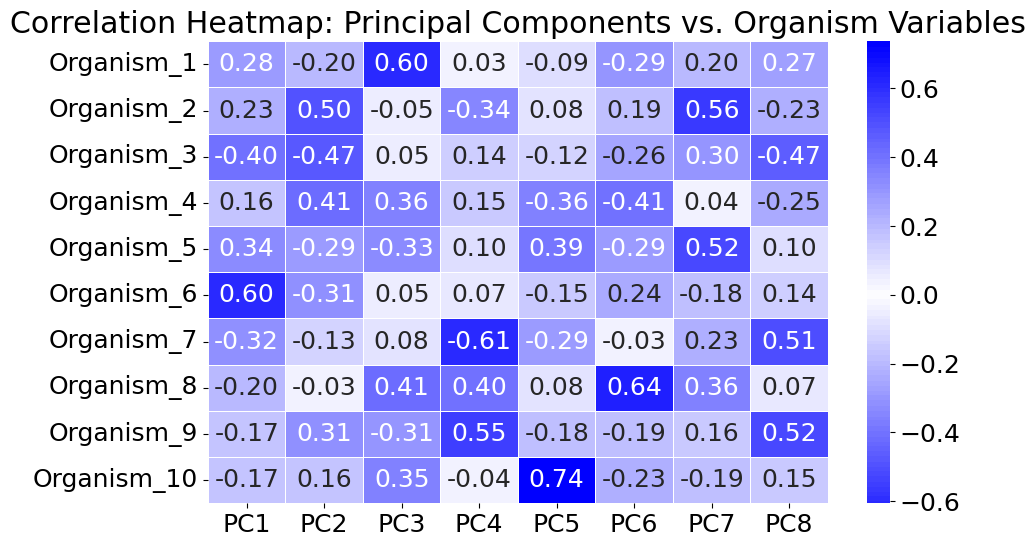

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Assuming pca_model, n, and organisms are already defined in your code

# Create a custom colormap that transitions from red (for high negative values) to white (for zero) to red (for high positive values)
colors = ["blue", "white", "blue"]
cmap_name = "custom_div_cmap"
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

component_variable_correlation = pd.DataFrame(pca_model.components_.T, columns=[f'PC{i}' for i in range(1, n+1)], index=organisms)
plt.figure(figsize=(10, 6))

sns.heatmap(component_variable_correlation, cmap=cm, annot=True, fmt=".2f", linewidths=0.5, center=0)

plt.title('Correlation Heatmap: Principal Components vs. Organism Variables')
plt.show()

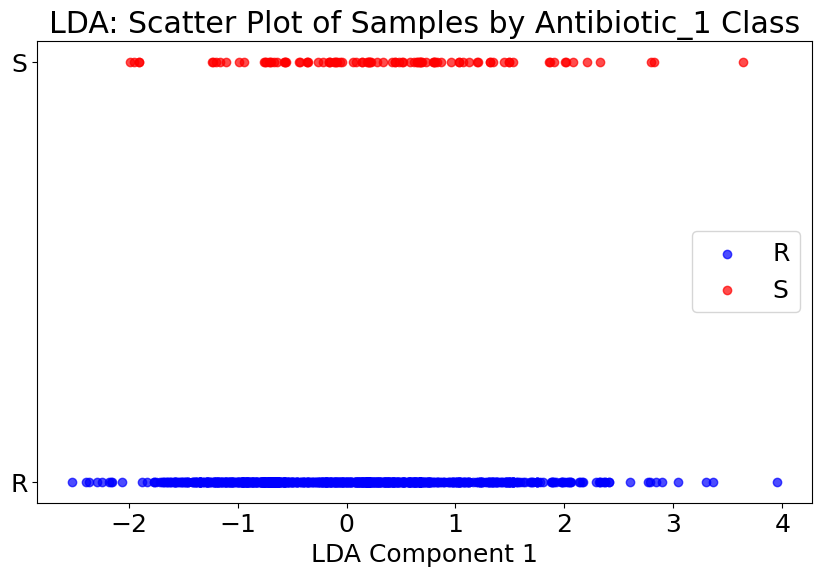

In [37]:
pred_data = dfh.select_columns_by_search_terms(df, ['organism' , 'gene'])

# Extract the features (organism count variables)
X = df[pred_data]

# Extract the class labels
y = df['Antibiotic_1']

# Initialize and fit the LDA model
lda = LinearDiscriminantAnalysis(n_components=1)  # You can choose the number of components
X_lda = lda.fit_transform(X, y)

# Create a scatter plot of the LDA results
plt.figure(figsize=(10, 6))
colors = ['blue', 'red']  # Define colors for the two classes ('Resistant' and 'Sensitive')
class_labels = df['Antibiotic_1'].unique()
for i, label in enumerate(class_labels):
    plt.scatter(X_lda[y == label], [i] * sum(y == label), c=colors[i], label=label, alpha=0.7)

plt.xlabel('LDA Component 1')
plt.yticks([0, 1], class_labels)
plt.title('LDA: Scatter Plot of Samples by Antibiotic_1 Class')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


y_true = df['Antibiotic_1']
y_pred = lda.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_true, y_pred)
print(cm)

precision = precision_score(y_true, y_pred, pos_label='R')
print(precision)
recall = recall_score(y_true, y_pred, pos_label='R')
print(recall)
f1 = f1_score(y_true, y_pred, pos_label='R')
print(f1)

Accuracy: 0.90
[[902   0]
 [ 98   0]]
0.902
1.0
0.9484752891692955


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Split the data into a 90% training set and a 10% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize and fit the LDA model on the training set
lda = LinearDiscriminantAnalysis(n_components=1)  # Use 1 component for binary classification
lda.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate other evaluation metrics (e.g., precision, recall, F1-score, confusion matrix)
precision = precision_score(y_test, y_pred, pos_label='R')
recall = recall_score(y_test, y_pred, pos_label='R')
f1 = f1_score(y_test, y_pred, pos_label='R')
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.93
Precision: 0.93
Recall: 1.00
F1-score: 0.96
Confusion Matrix:
[[93  0]
 [ 7  0]]


In [22]:
pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Split the data into a 90% training set and a 10% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize and fit the SMOTE oversampler on the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# Initialize and fit the LDA model on the resampled training set
lda = LinearDiscriminantAnalysis(n_components=1)  # Use 1 component for binary classification
lda.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate other evaluation metrics (e.g., precision, recall, F1-score, confusion matrix)
precision = precision_score(y_test, y_pred, pos_label='R')
recall = recall_score(y_test, y_pred, pos_label='R')
f1 = f1_score(y_test, y_pred, pos_label='R')
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.51
Precision: 0.91
Recall: 0.53
F1-score: 0.67
Confusion Matrix:
[[49 44]
 [ 5  2]]


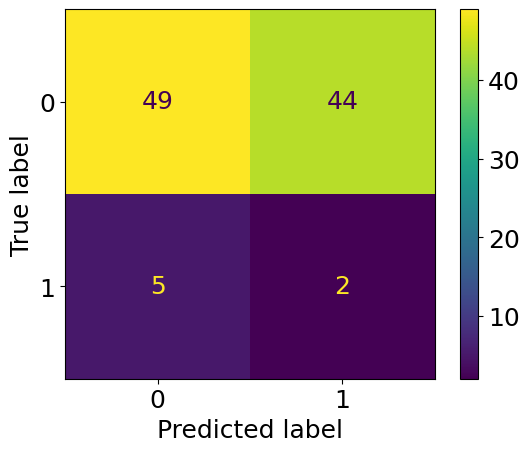

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

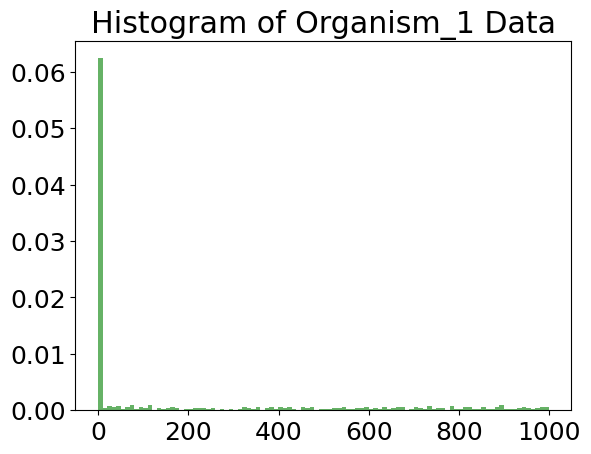

Anderson-Darling test result for Normal: 155.42471722398568
    15.0% significance: Data does not look normal (reject H0)
    10.0% significance: Data does not look normal (reject H0)
    5.0% significance: Data does not look normal (reject H0)
    2.5% significance: Data does not look normal (reject H0)
    1.0% significance: Data does not look normal (reject H0)
K-S test result for Normal: statistic=0.3536530987356431, p-value=2.2149247498683016e-112
K-S test result for Exponential: statistic=0.62, p-value=0.0
K-S test result for Log-Normal: statistic=0.6155815820179688, p-value=0.0
K-S test result for T-distribution: statistic=0.4862990466789211, p-value=2.272455611002191e-218
K-S test result for Beta distribution: statistic=0.6199984297622257, p-value=0.0


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [68]:

from scipy.stats import (norm, expon, lognorm, anderson, kstest, chi2,
                         chi2_contingency, t, beta)

# Assuming df has already been defined somewhere in your code
odata = df['Organism_1']
#odata = df[df['Organism_1'] > 0]['Organism_1']

# 1. Data Visualization using Histogram
plt.hist(odata, bins=100, density=True, alpha=0.6, color='g')
plt.title("Histogram of Organism_1 Data")
plt.show()

# 2. Statistical Tests

# Anderson-Darling Test for multiple distributions
result = anderson(odata)
print("Anderson-Darling test result for Normal:", result.statistic)
for i in range(len(result.critical_values)):
    sig, crit = result.significance_level[i], result.critical_values[i]
    if result.statistic < crit:
        print(f'    {sig}% significance: Data looks normal (fail to reject H0)')
    else:
        print(f'    {sig}% significance: Data does not look normal (reject H0)')

# 3. Parameter Estimation for different distributions

# Normal Distribution
params_norm = norm.fit(odata)

# Exponential Distribution
params_expon = expon.fit(odata)

# Log-normal Distribution
params_lognorm = lognorm.fit(odata)

# T-distribution
params_t = t.fit(odata)

# Beta distribution
params_beta = beta.fit(odata)

# 4. Goodness of Fit Comparison using Kolmogorov-Smirnov test

ks_stat_norm, ks_p_norm = kstest(odata, 'norm', args=params_norm)
ks_stat_expon, ks_p_expon = kstest(odata, 'expon', args=params_expon)
ks_stat_lognorm, ks_p_lognorm = kstest(odata, 'lognorm', args=params_lognorm)
ks_stat_t, ks_p_t = kstest(odata, 't', args=params_t)
ks_stat_beta, ks_p_beta = kstest(odata, 'beta', args=params_beta)

print(f"K-S test result for Normal: statistic={ks_stat_norm}, p-value={ks_p_norm}")
print(f"K-S test result for Exponential: statistic={ks_stat_expon}, p-value={ks_p_expon}")
print(f"K-S test result for Log-Normal: statistic={ks_stat_lognorm}, p-value={ks_p_lognorm}")
print(f"K-S test result for T-distribution: statistic={ks_stat_t}, p-value={ks_p_t}")
print(f"K-S test result for Beta distribution: statistic={ks_stat_beta}, p-value={ks_p_beta}")

# Interpretation remains the same: higher p-values indicate that the observed data is consistent with the proposed distribution.


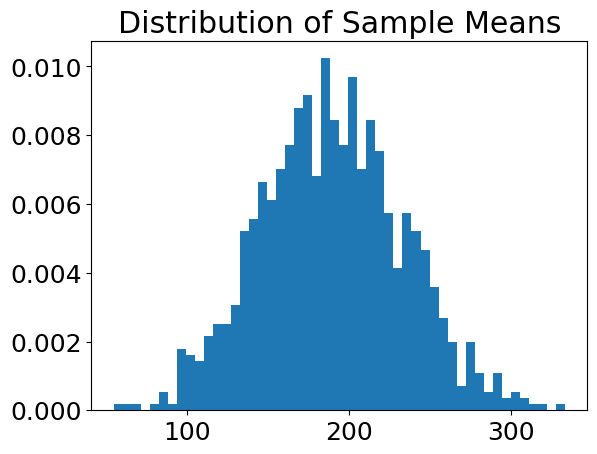

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'odata' has been defined as your dataset
sample_means = []

n = 50  # Size of each sample
samples = 1000  # Number of samples

for _ in range(samples):
    sample = np.random.choice(odata, n)
    sample_means.append(np.mean(sample))

plt.hist(sample_means, bins=50, density=True)
plt.title('Distribution of Sample Means')
plt.show()


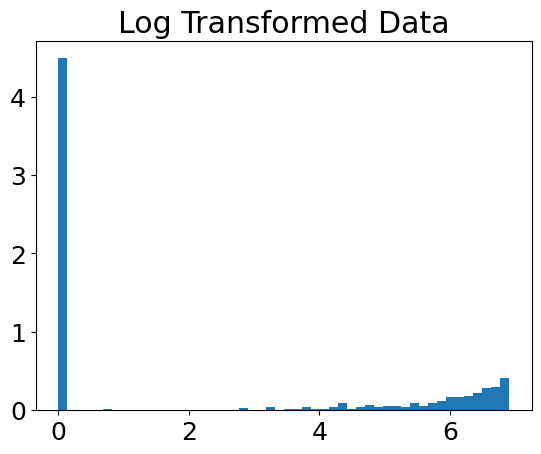

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'odata' has been defined as your dataset

# Add a small constant if there's any chance of having zeros in your data
odata_log_transformed = np.log(odata + 1)  # "+ 1" to handle potential zeros

plt.hist(odata_log_transformed, bins=50, density=True)
plt.title('Log Transformed Data')
plt.show()


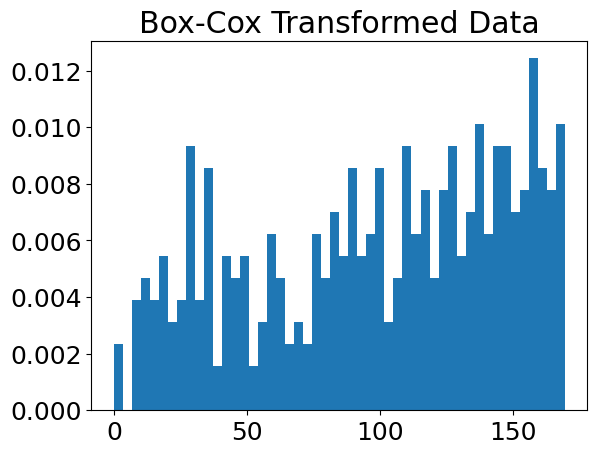

Optimal lambda value: 0.6905908894703109


In [71]:
from scipy.stats import boxcox

# The Box-Cox transformation requires all data to be positive.
odata_boxcox_transformed, lambda_val = boxcox(odata[odata > 0])

plt.hist(odata_boxcox_transformed, bins=50, density=True)
plt.title('Box-Cox Transformed Data')
plt.show()

print(f"Optimal lambda value: {lambda_val}")


In [73]:
import statsmodels.api as sm

# Assuming 'odata' is your data series
y = odata.values

# Using a constant model for simplicity
X = np.ones((len(y), 1))

zip_model = sm.ZeroInflatedPoisson(y, X).fit()
print(zip_model.summary())

Optimization terminated successfully.
         Current function value: 43.433970
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 1000
Model:             ZeroInflatedPoisson   Df Residuals:                      999
Method:                            MLE   Df Model:                            0
Date:                 Thu, 14 Sep 2023   Pseudo R-squ.:               2.837e-13
Time:                         16:59:46   Log-Likelihood:                -43434.
converged:                        True   LL-Null:                       -43434.
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     0.4895

/usr/local/lib/python3.8/site-packages/statsmodels/discrete/count_model.py:638: RuntimeWarning: overflow encountered in square
  coeff**2)).sum() - (mu[nonzero_idx] * self.exog[nonzero_idx, i] *
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/count_model.py:638: RuntimeWarning: overflow encountered in square
  coeff**2)).sum() - (mu[nonzero_idx] * self.exog[nonzero_idx, i] *


Optimization terminated successfully.
         Current function value: 43.433970
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10


/usr/local/lib/python3.8/site-packages/statsmodels/discrete/count_model.py:638: RuntimeWarning: overflow encountered in square
  coeff**2)).sum() - (mu[nonzero_idx] * self.exog[nonzero_idx, i] *


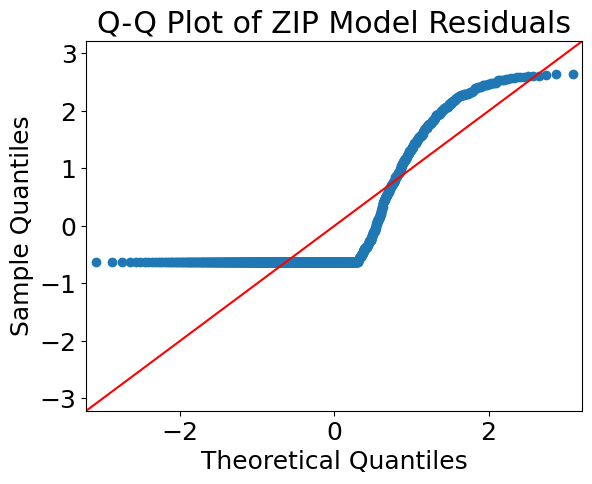

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.gofplots as smqq

# Fit a Zero-Inflated Poisson regression model

model = sm.ZeroInflatedPoisson(y, X).fit()

# Calculate the residuals manually
predicted_counts = model.predict()
residuals = y - predicted_counts

# Create a Q-Q plot for the residuals
smqq.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of ZIP Model Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

In [72]:
import statsmodels.api as sm

# Assuming 'odata' is your data series
y = odata.values

# Using a constant model for simplicity
X = np.ones((len(y), 1))

zinb_model = sm.ZeroInflatedNegativeBinomialP(y, X).fit()
print(zinb_model.summary())

         Current function value: nan
         Iterations: 22
         Function evaluations: 136
         Gradient evaluations: 136
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                 1000
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      999
Method:                                      MLE   Df Model:                            0
Date:                           Thu, 14 Sep 2023   Pseudo R-squ.:                     nan
Time:                                   16:59:42   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                       -3387.1
Covariance Type:                       nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3935: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3972: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:4325: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3935: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3972: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3975: RuntimeWarning: invalid value encountered in multip